# Appendix A

## Assignment 4: Build Non-Linear Models Part 2
Dawud Ujamaa  
School of Technology & Engineering, National University  
TIM-8555: Predictive Analysis  
Dr. Larry Fulton  
December 1, 2024 

### __2. Complete Applied Question #8 on page 327 of ISLR Python.__
Fit some of the non-linear models investigated in this chapter to the __`Auto`__ data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize , poly , ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam , l as l_gam, f as f_gam, LinearGAM , LogisticGAM)
from ISLP.transforms import (BSpline , NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam , degrees_of_freedom , plot as plot_gam , anova as anova_gam)

In [2]:
# import Auto data set
# https://islp.readthedocs.io/en/latest/datasets/Auto.html

from ISLP import load_data
Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


In [3]:
# check for missing values
missing_values = Auto.isnull().sum()
print(missing_values)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64


In [4]:
# Generate descriptive statistics
Auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


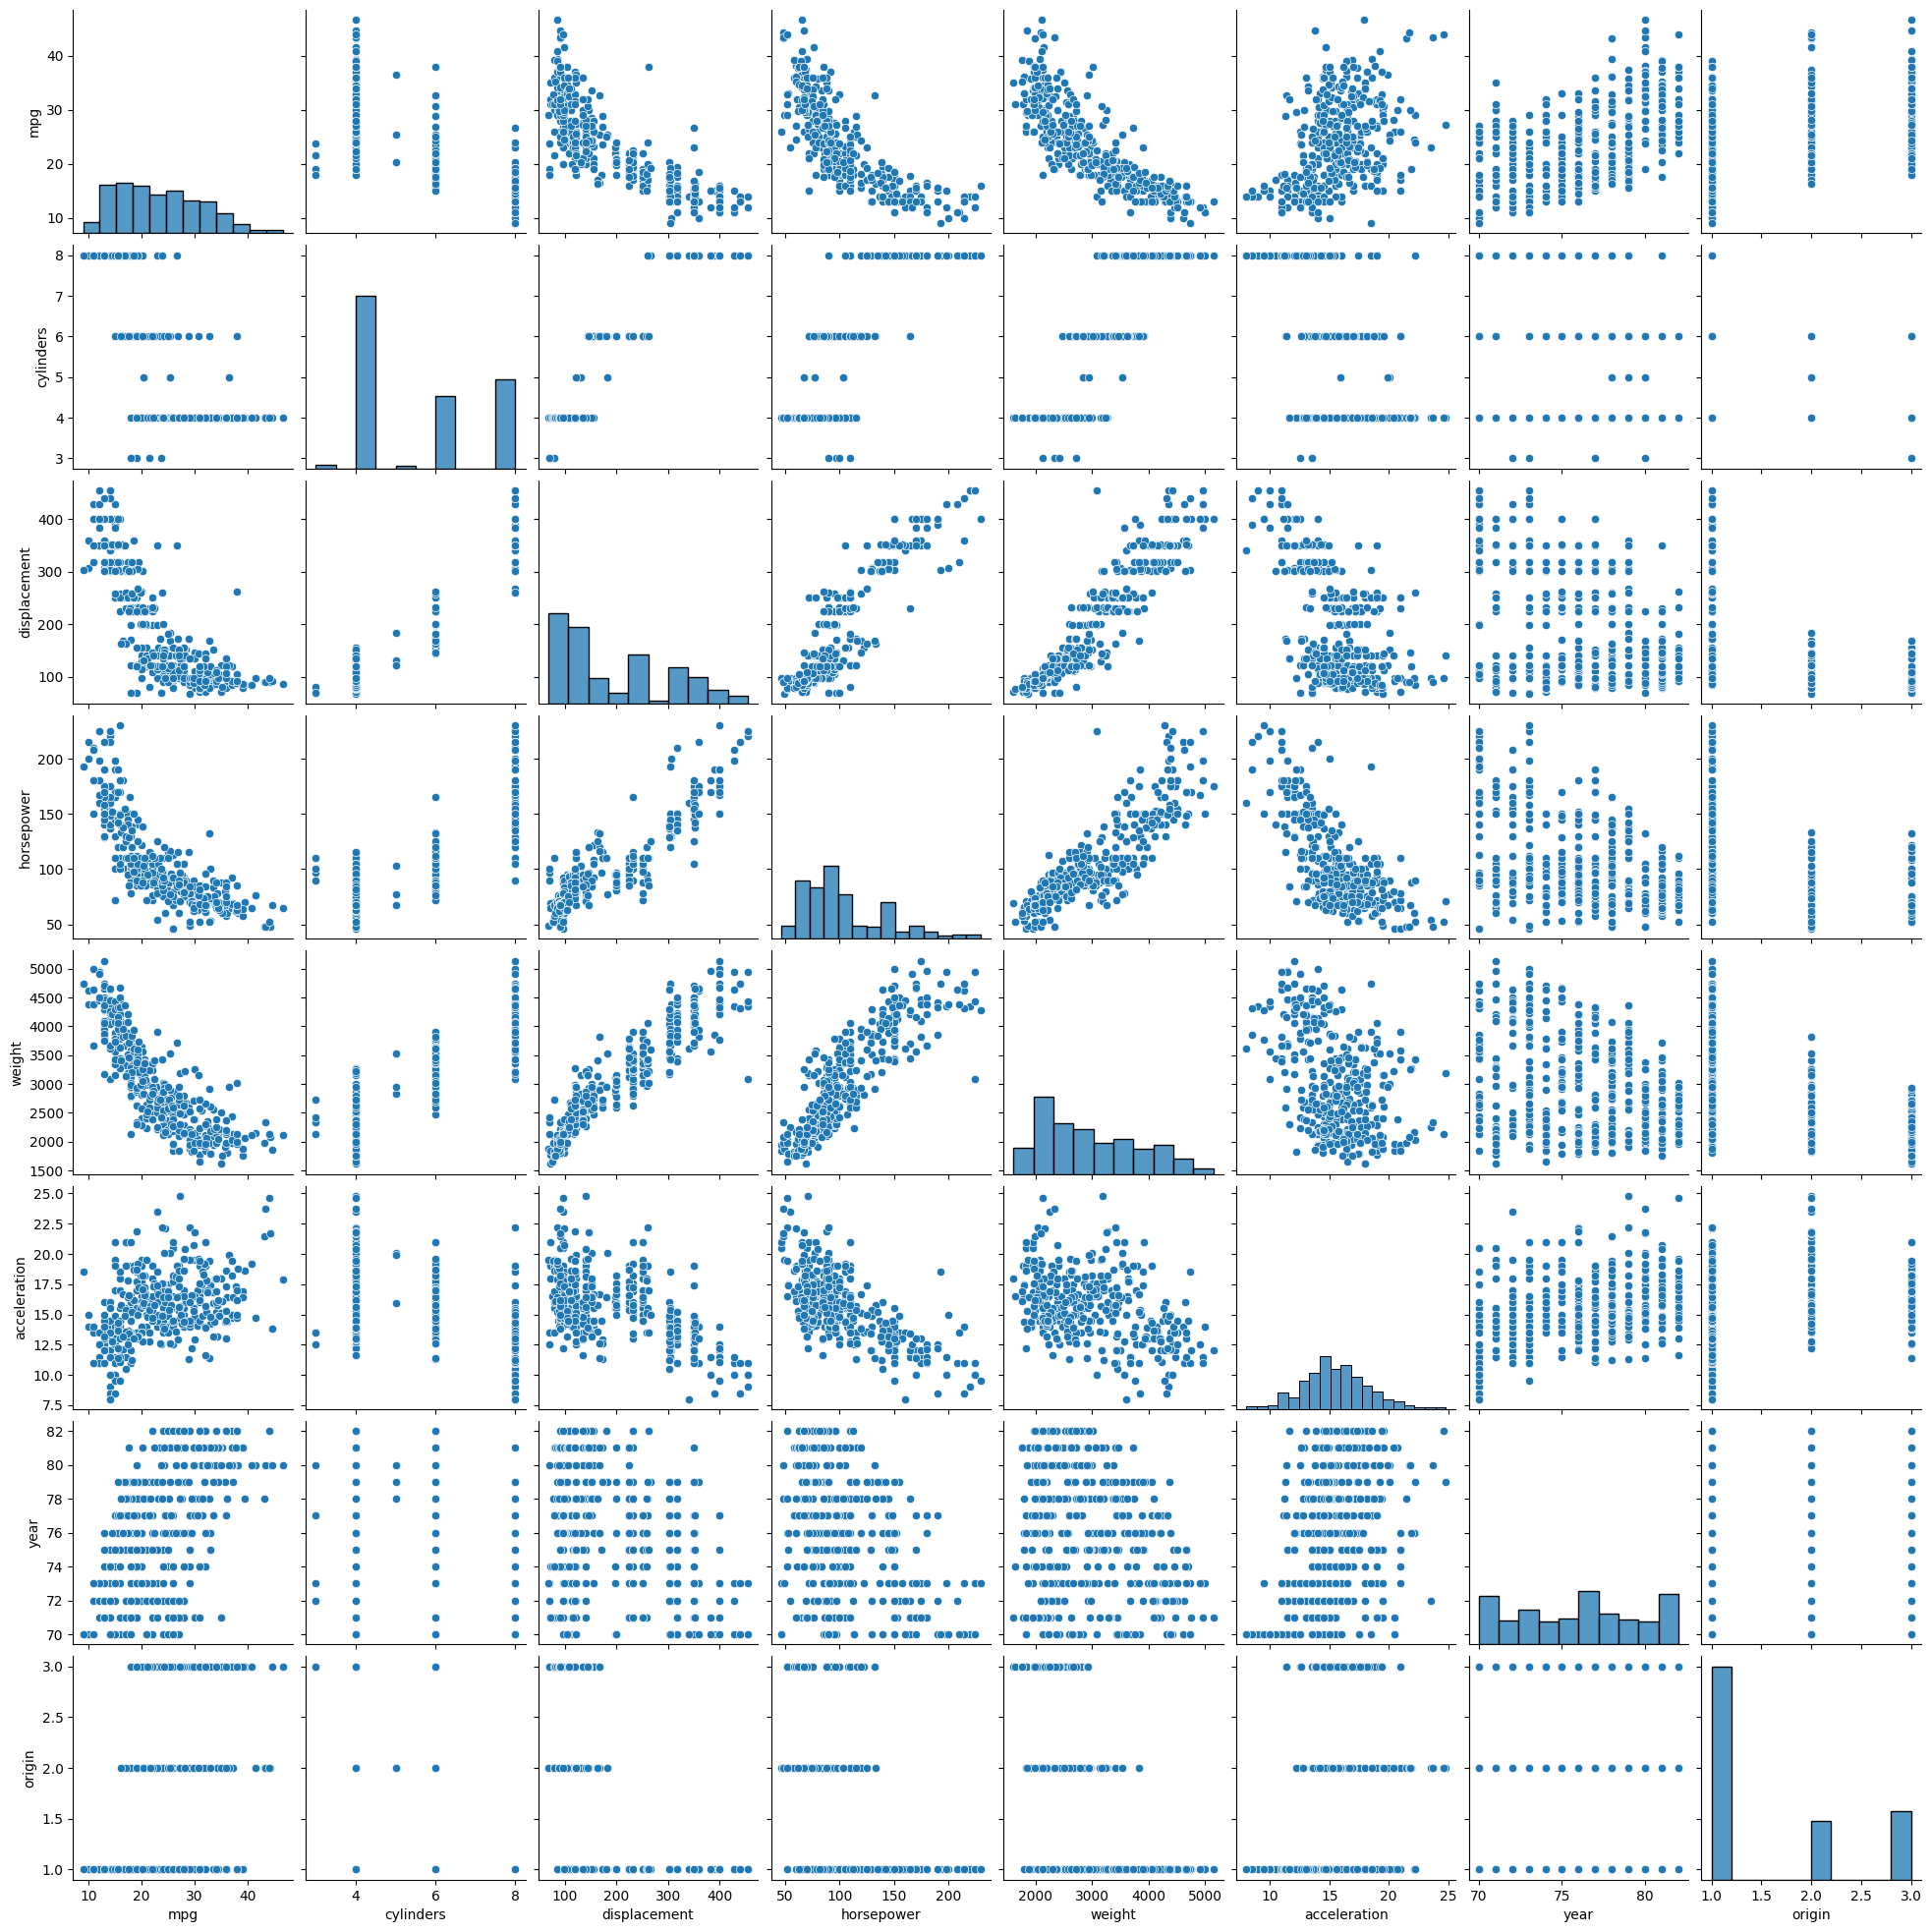

In [5]:
# generate pairs plot to check distribution of variables and
# assess linear relationship between independent variables and the dependent variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(Auto[['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin']])
plt.show()

In [6]:
# Best Subset Selection

from ISLP.models import ModelSpec as MS
from l0bnb import fit_path

design = MS(Auto.columns.drop('mpg')).fit(Auto)
Y = np.array(Auto['mpg'])
D = design.fit_transform(Auto)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  3
Iteration: 4. Number of non-zeros:  6
Iteration: 5. Number of non-zeros:  7


In [7]:
#Best 1 predictor
pd.DataFrame(zip(D.columns, path[0]['B']))

,0,1
0,cylinders,0.000000
1,displacement,0.000000
2,horsepower,0.000000
3,weight,-0.007497
4,acceleration,0.000000
5,year,0.000000
6,origin,0.000000


In [8]:
#Best 2 predictors
pd.DataFrame(zip(D.columns, path[1]['B']))

,0,1
0,cylinders,0.000000
1,displacement,0.000000
2,horsepower,0.000000
3,weight,-0.006510
4,acceleration,0.000000
5,year,0.750973
6,origin,0.000000


In [9]:
#Best 3 predictors
pd.DataFrame(zip(D.columns, path[2]['B']))

,0,1
0,cylinders,0.000000
1,displacement,0.000000
2,horsepower,0.000000
3,weight,-0.005847
4,acceleration,0.000000
5,year,0.749750
6,origin,1.222910


#### Polynomial Regression on `Auto` data set

Perform hypothesis tests decide on the degree of the polynomial to use

In [10]:
# perform hypothesis tests decide on the degree of the polynomial to use
y = Auto['mpg']

models = [MS([poly('weight', degree=d)])
          for d in range(1, 5)]

Xs = [model.fit_transform(Auto) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,7321.233706,0.0,NaN,NaN,NaN
1,389.0,6784.898509,1.0,536.335198,30.627530,5.755724e-08
2,388.0,6784.849925,1.0,0.048584,0.002774,9.580201e-01
3,387.0,6776.965652,1.0,7.884272,0.450233,5.026246e-01


The hypothesis test in the ANOVA table tests the null hypothesis that there is no difference between two models, against the alternative hypothesis that the larger model is statistically significantly better. The null hypothesis is rejected in favor of the alternative hypothesis when the p-value is less than $\alpha$ (0.05).  
*  The p-value comparing the linear models[0] to the quadratic models[1] is 0.000000058, which is statistically significant and shows that a quadratic model is better than a linear model.
* The p-value comparing the quadratic models[1] to the cubic models[2] is 0.958, which is not statistically significant, therefore the null hypothesis cannot be rejected, thus there is no difference between the quadratic and cubic models, so the simpler quadratic model is selected.

In [11]:
# perform quadratic polynomial regression
weight = Auto['weight']

poly_weight = MS([poly('weight', degree=2)]).fit(Auto)
M = sm.OLS(y, poly_weight.transform(Auto)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,23.4459,0.211,111.151,0.0
"poly(weight, degree=2)[0]",-128.4436,4.176,-30.755,0.0
"poly(weight, degree=2)[1]",23.1589,4.176,5.545,0.0


In [12]:
# Create a grid of values for weight at which we want predictions.
weight_grid = np.linspace(weight.min(), weight.max(), 100)
weight_df = pd.DataFrame({'weight': weight_grid})

Plot the data and add the fit from the quadratic (degree-2) polynomial.

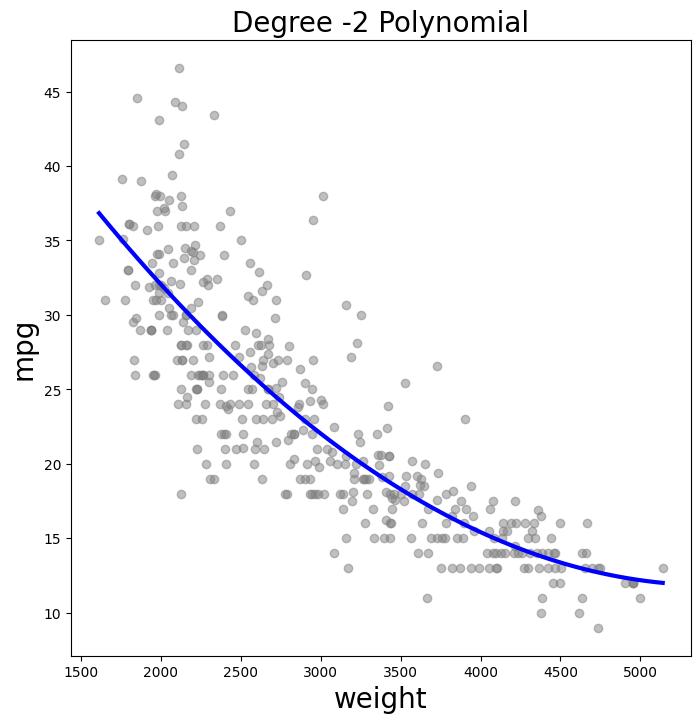

In [13]:
def plot_auto_fit(weight_df , basis , title):
    X = basis.transform(Auto)
    Xnew = basis.transform(weight_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig , ax = subplots(figsize=(8,8))
    ax.scatter(weight , y, facecolor='gray', alpha=0.5)
    for val , ls in zip([preds.predicted_mean , bands[:,0], bands[:,1]], ['b','r--','r--']):
        ax.plot(weight_df.values , val , ls, linewidth=3)
        ax.set_title(title , fontsize =20)
        ax.set_xlabel('weight', fontsize=20)
        ax.set_ylabel('mpg', fontsize=20);
        return ax

plot_auto_fit(weight_df , poly_weight , 'Degree -2 Polynomial');

#### Step Function Regression on `Auto` data set
Predict whether a vehicle gets more than 25 mpg

In [14]:
X = poly_weight.transform(Auto)
high_mpg = Auto['high_mpg'] = y > 25 
glm = sm.GLM(y > 25, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-1.0610,0.319,-3.331,0.001
"poly(weight, degree=2)[0]",-53.2066,8.541,-6.229,0.000
"poly(weight, degree=2)[1]",8.5682,6.576,1.303,0.193


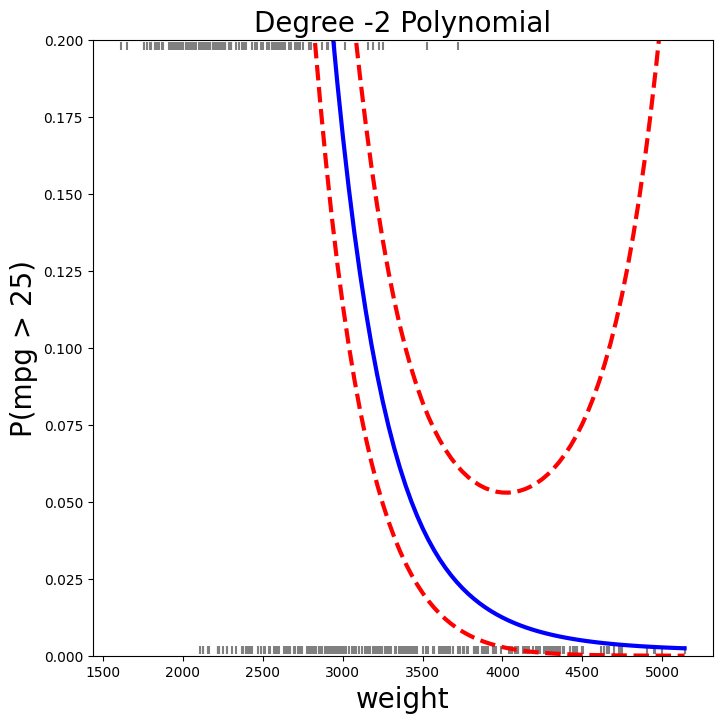

In [15]:
# make predictions

newX = poly_weight.transform(weight_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

# plot the estimated relationship.

fig , ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(weight + 0.2 * rng.uniform(size=y.shape[0]), np.where(high_mpg , 0.198, 0.002), fc='gray', marker='|')
for val , ls in zip([preds.predicted_mean , bands[:,0], bands[:,1]], ['b','r--','r--']):
    ax.plot(weight_df.values , val , ls, linewidth=3)
    ax.set_title('Degree -2 Polynomial', fontsize=20)
    ax.set_xlabel('weight', fontsize=20)
    ax.set_ylim ([0,0.2])
    ax.set_ylabel('P(mpg > 25)', fontsize=20);

The rug plot above shows the weight values corresponding to the observations with mpg values above 25 as gray marks on the top of the plot, and those with mpg values below 25 are shown as gray marks on the bottom of the plot. 

To fit a step function, the `pd.qcut()` function is used to discretize weight based on quantiles. 
Next, `pd.get_dummies()` is used to create the columns of the model matrix for this categorical variables. 

In [16]:
cut_weight = pd.qcut(weight , 4)
step_weight = sm.OLS(y, pd.get_dummies(cut_weight)).fit()
summarize(step_weight)

,coef,std err,t,P>|t|
"(1612.999, 2225.25]",32.3235,0.435,74.260,0.0
"(2225.25, 2803.5]",26.1633,0.435,60.107,0.0
"(2803.5, 3614.75]",20.4878,0.435,47.069,0.0
"(3614.75, 5140.0]",14.8092,0.435,34.023,0.0


* The value 32.32 is the average mpg for vehicles between 1613.00 lbs and 2225.25 lbs
* The value 26.16 is the average mpg for vehicles between 2225.25 lbs and 2803.50 lbs
* The value 20.49 is the average mpg for vehicles between 2803.50 lbs and 3614.75 lbs
* The value 14.81 is the average mpg for vehicles between 3614.75 lbs and 5140.00 lbs

#### Regression Splines on `Auto` data set

In [17]:
ns_weight = MS([ns('weight', df=5)]).fit(Auto)
M_ns = sm.OLS(y, ns_weight.transform(Auto)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,35.6859,1.591,22.423,0.0
"ns(weight, df=5)[0]",-10.8850,1.553,-7.010,0.0
"ns(weight, df=5)[1]",-15.0314,1.991,-7.549,0.0
"ns(weight, df=5)[2]",-19.6977,1.433,-13.745,0.0
"ns(weight, df=5)[3]",-26.6770,3.648,-7.312,0.0
"ns(weight, df=5)[4]",-21.7589,1.674,-12.997,0.0


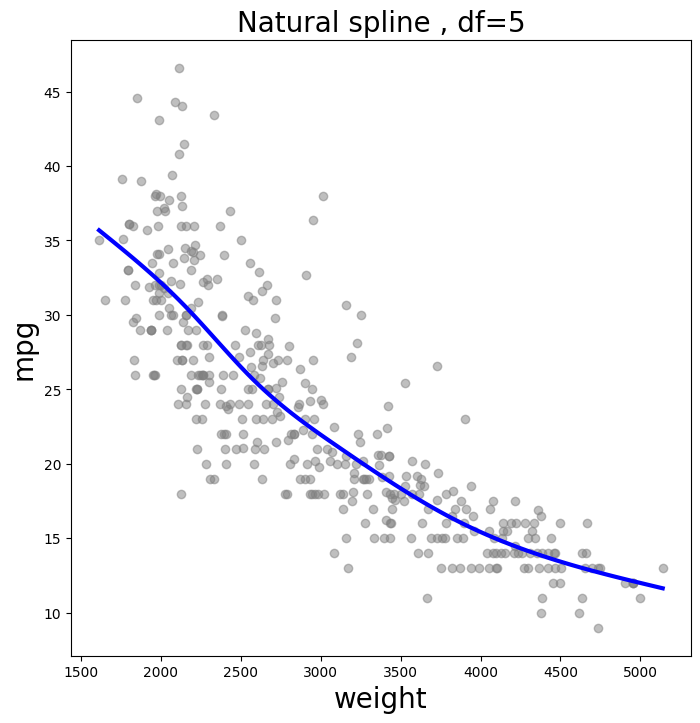

In [18]:
# plot the natural spline 
plot_auto_fit(weight_df , ns_weight , 'Natural spline , df=5');

#### GAM multivariate regression on `Auto` data set

Best subset selection identified weight, year, and origin as the best 3 predictors of mpg.

Fit a GAM to predict mpg using smoothing spline functions of year and weight, with origin as a qualitative predictor
* convert the categorical variable origin to its array representation using the cat.codes attribute
* use n_splines=13 since year only has 13 unique values

In [19]:
# Get unique value counts for year
Auto.year.value_counts(dropna=False)

73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: year, dtype: int64

In [20]:
# Convert origin to a categorical variable
Auto['origin_cat'] = Auto['origin'].astype('category',copy=False)

In [21]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=13) + f_gam(2, lam=0))
Xgam = np.column_stack([weight , Auto['year'], Auto['origin_cat'].cat.codes])
gam_full = gam_full.fit(Xgam , y)

In [22]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.5741
Link Function:                     IdentityLink Log Likelihood:                                 -1180.4133
Number of Samples:                          392 AIC:                                             2405.9747
                                                AICc:                                            2408.8636
                                                GCV:                                                8.4489
                                                Scale:                                              7.6162
                                                Pseudo R-Squared:                                   0.8816
Feature Function                  Lam

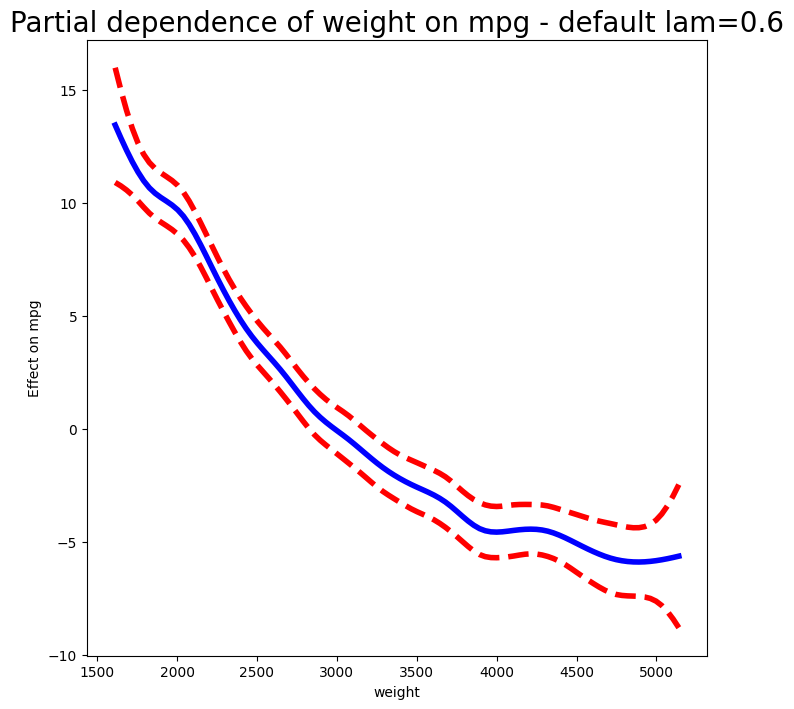

In [23]:
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full , 0, ax=ax)
ax.set_xlabel('weight')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of weight on mpg - default lam=0.6',
fontsize=20);

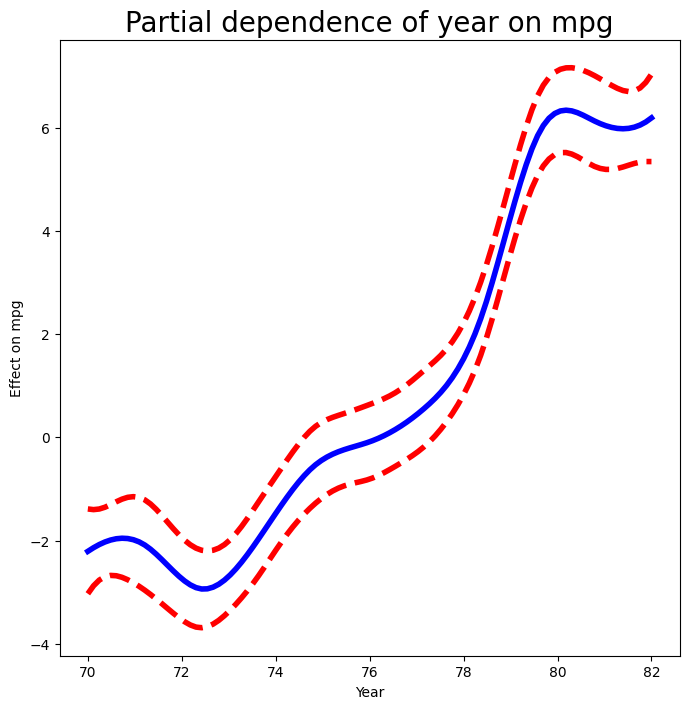

In [24]:
fig , ax = subplots(figsize=(8,8))
plot_gam(gam_full , 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of year on mpg', fontsize=20);

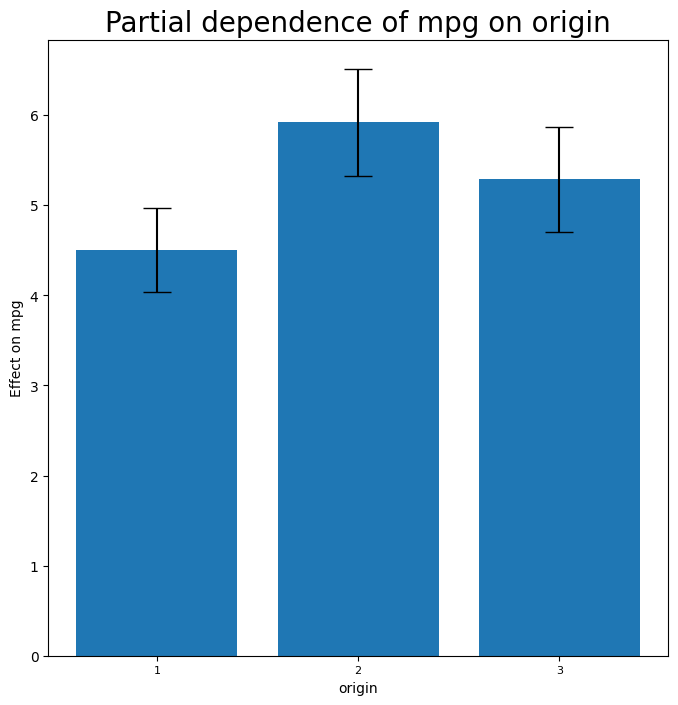

In [25]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full , 2)
ax.set_xlabel('origin')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of mpg on origin', fontsize =20);
ax.set_xticklabels(Auto['origin_cat'].cat.categories , fontsize =8);

### __3. Continue competing in the Regression with Abalone Dataset competition (late submission) on Kaggle.com__
https://www.kaggle.com/competitions/playground-series-s4e4 

Build two models with nonlinearity methods discussed in this week’s lecture and text. 
Interpret your regression models, investigate assumptions, and interpret all findings.

#### EDA, Preprocessing, and Feature Engineering
The EDA conducted on the data set in week 2 revealed the need for certain data preprocessing and feature engineering steps that will be performed. 1) variables will be renamed to not contain blank character spaces; 2) the distribution of response variable was skewed, so the data will be transformed with the transformation $\sqrt{x+1}$; and 3) Dummy variables will be created for the qualitative Sex variable.

In [26]:
# import training data
AbaloneTrain = pd.read_csv(r'./train.csv',index_col=0)

# rename variables
AbaloneTrain.rename(columns={"Whole weight":"Whole_weight","Whole weight.1":"Whole_weight1",
                            "Whole weight.2":"Whole_weight2","Shell weight":"Shell_weight"},inplace=True)

# Create new square root transformed features
AbaloneTrain['Length_Trans'] = np.sqrt(AbaloneTrain['Length']+1)
AbaloneTrain['Diameter_Trans'] = np.sqrt(AbaloneTrain['Diameter']+1)
AbaloneTrain['Height_Trans'] = np.sqrt(AbaloneTrain['Height']+1)
AbaloneTrain['Whole_weight_Trans'] = np.sqrt(AbaloneTrain['Whole_weight']+1)
AbaloneTrain['Whole_weight1_Trans'] = np.sqrt(AbaloneTrain['Whole_weight1']+1)
AbaloneTrain['Whole_weight2_Trans'] = np.sqrt(AbaloneTrain['Whole_weight2']+1)
AbaloneTrain['Shell_weight_Trans'] = np.sqrt(AbaloneTrain['Shell_weight']+1)
AbaloneTrain['Rings_Trans'] = np.sqrt(AbaloneTrain['Rings']+1)

# Generate dummy variables for sex
Sex = AbaloneTrain['Sex']
AbaloneTrain = pd.get_dummies(AbaloneTrain,columns=['Sex'])
AbaloneTrain['Sex'] = Sex
AbaloneTrain

,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Rings,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Rings_Trans,Sex_F,Sex_I,Sex_M,Sex
id,,,,,,,,,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1.244990,1.195826,1.072381,1.330977,1.152606,1.070747,1.113553,3.464102,1,0,0,F
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1.276715,1.220656,1.070047,1.459452,1.207477,1.129823,1.148913,3.464102,1,0,0,F
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,1.077033,1.053565,1.012423,1.010445,1.002746,1.001499,1.002497,2.645751,0,1,0,I
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,1.262933,1.214496,1.072381,1.383655,1.172817,1.097953,1.118034,3.316625,0,0,1,M
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,1.246996,1.193734,1.063015,1.334916,1.170256,1.077033,1.094303,3.162278,0,1,0,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,1.155422,1.111306,1.036822,1.076336,1.033683,1.018332,1.022252,2.645751,0,0,1,M
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,1.246996,1.193734,1.072381,1.370766,1.177497,1.086968,1.113553,3.162278,0,0,1,M
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,1.197915,1.153256,1.046422,1.149565,1.072847,1.038509,1.039952,2.645751,0,1,0,I


#### __Abalone Regression Model 5 - Polynomial Regression with Best Subset Selection to inform variable subset selection__

In [27]:
AbaloneTrainModelFeatures = AbaloneTrain[['Length_Trans','Diameter_Trans','Height_Trans','Whole_weight_Trans','Whole_weight1_Trans',
                                     'Whole_weight2_Trans','Shell_weight_Trans','Rings_Trans','Sex_F','Sex_M']]
design = MS(AbaloneTrainModelFeatures.columns.drop('Rings_Trans')).fit(AbaloneTrainModelFeatures)
Y = np.array(AbaloneTrainModelFeatures['Rings_Trans'])
D = design.fit_transform(AbaloneTrainModelFeatures)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  4
Iteration: 3. Number of non-zeros:  7
Iteration: 4. Number of non-zeros:  9


In [28]:
#Best 1 predictor
pd.DataFrame(zip(D.columns, path[0]['B']))

,0,1
0,Length_Trans,0.00000
1,Diameter_Trans,0.00000
2,Height_Trans,0.00000
3,Whole_weight_Trans,0.00000
4,Whole_weight1_Trans,0.00000
5,Whole_weight2_Trans,0.00000
6,Shell_weight_Trans,5.70869
7,Sex_F,0.00000
8,Sex_M,0.00000


In [29]:
#Best 4 predictors
pd.DataFrame(zip(D.columns, path[1]['B']))

,0,1
0,Length_Trans,0.000000
1,Diameter_Trans,3.481029
2,Height_Trans,8.138639
3,Whole_weight_Trans,0.000000
4,Whole_weight1_Trans,-3.673189
5,Whole_weight2_Trans,0.000000
6,Shell_weight_Trans,6.164565
7,Sex_F,0.000000
8,Sex_M,0.000000


Since there is high multicollinearity between the features, the polynomial regression wil use the best 1 predictor, Shell_weight, along with the sex dummy variables, which is a polynomial version of Model2 built in week 2.

ANOVA hypotheses tests will be performed to decide on the degree of the polynomial to use

In [30]:
# perform hypothesis tests decide on the degree of the polynomial to use
y = AbaloneTrainModelFeatures['Rings_Trans']

models = [MS([poly('Shell_weight_Trans', degree=d)]) 
          for d in range(1, 10)]

Xs = [model.fit_transform(AbaloneTrainModelFeatures) 
       for model in models]

anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,90613.0,9294.090175,0.0,NaN,NaN,NaN
1,90612.0,8849.383222,1.0,444.706953,4648.333912,0.000000e+00
2,90611.0,8765.295020,1.0,84.088202,878.938453,3.106269e-192
3,90610.0,8709.191380,1.0,56.103641,586.427654,3.869495e-129
4,90609.0,8705.471002,1.0,3.720378,38.887541,4.509090e-10
5,90608.0,8688.053546,1.0,17.417455,182.057302,1.889470e-41
6,90607.0,8673.932395,1.0,14.121151,147.602427,6.158431e-34
7,90606.0,8668.212023,1.0,5.720373,59.792639,1.064761e-14
8,90605.0,8668.196868,1.0,0.015155,0.158407,6.906288e-01


The ANOVA test suggests a degree-8 polynomial for Shell_weight_Trans

Build the degree-8 polynomial regression model with Shell_weight and Sex_F and Sex_M

In [31]:
poly_Abalone = MS([poly('Shell_weight_Trans', degree=8),'Sex_F','Sex_M']).fit(AbaloneTrainModelFeatures)
Model5 = sm.OLS(y, poly_Abalone.transform(AbaloneTrainModelFeatures)).fit()
summarize(Model5)

,coef,std err,t,P>|t|
intercept,3.1827,0.002,1453.406,0.0
"poly(Shell_weight_Trans, degree=8)[0]",93.9714,0.424,221.440,0.0
"poly(Shell_weight_Trans, degree=8)[1]",-18.1246,0.326,-55.645,0.0
"poly(Shell_weight_Trans, degree=8)[2]",9.6344,0.308,31.233,0.0
"poly(Shell_weight_Trans, degree=8)[3]",-8.9719,0.313,-28.705,0.0
"poly(Shell_weight_Trans, degree=8)[4]",2.9259,0.310,9.434,0.0
"poly(Shell_weight_Trans, degree=8)[5]",-4.2670,0.308,-13.855,0.0
"poly(Shell_weight_Trans, degree=8)[6]",3.4084,0.308,11.058,0.0
"poly(Shell_weight_Trans, degree=8)[7]",-2.0257,0.308,-6.572,0.0
Sex_F,0.0925,0.003,27.066,0.0


In [32]:
#view model summary
print(Model5.summary())

                            OLS Regression Results                            
Dep. Variable:            Rings_Trans   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                 1.176e+04
Date:                Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:40:32   Log-Likelihood:                -21844.
No. Observations:               90615   AIC:                         4.371e+04
Df Residuals:                   90604   BIC:                         4.381e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

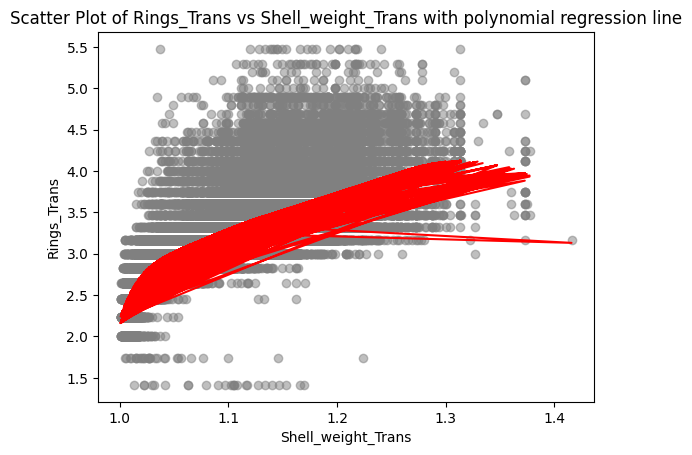

In [33]:
y_pred = Model5.predict(poly_Abalone.transform(AbaloneTrainModelFeatures))

# Create the scatter plot
plt.scatter(AbaloneTrainModelFeatures['Shell_weight_Trans'], y, facecolor='gray', alpha=0.5)

# Plot the regression line
plt.plot(AbaloneTrainModelFeatures['Shell_weight_Trans'], Model5.fittedvalues, color='red')

plt.xlabel('Shell_weight_Trans')
plt.ylabel('Rings_Trans')
plt.title('Scatter Plot of Rings_Trans vs Shell_weight_Trans with polynomial regression line')

# Show the plot
plt.show()

##### __Evaluate Model5__

In [34]:
# define function to calculate ME, MPE, MAPE, MAE, MSE, RMSLE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def myf(y,yhat):
    r2 = r2_score(y, yhat)
    ME=np.round(np.mean(y-yhat),3)
    MPE=np.round(np.mean((y-yhat)/y),3)
    myMAE=np.round(MAE(y,yhat),3)
    myMSE=np.round(MSE(y,yhat),3)
    myMAPE=np.round(MAPE(y,yhat),3)
    myRMSLE=np.round(rmsle(y,yhat),3)
    print("\n","R-squared:", np.round(r2,3),"\n","ME:", np.round(ME,3),"\n","MPE:",MPE,"\n", 
          "MAE:", myMAE,"\n", "MSE:", myMSE,"\n","MAPE:",myMAPE,"\n","RMSLE:",myRMSLE)

In [35]:
# evaluate Model5
y_pred = Model5.predict(poly_Abalone.transform(AbaloneTrainModelFeatures))
myf(y, y_pred)


 R-squared: 0.565 
 ME: 0.0 
 MPE: -0.008 
 MAE: 0.224 
 MSE: 0.095 
 MAPE: 0.066 
 RMSLE: 0.068


##### __Assess residuals of Model5 to investigate assumptions__

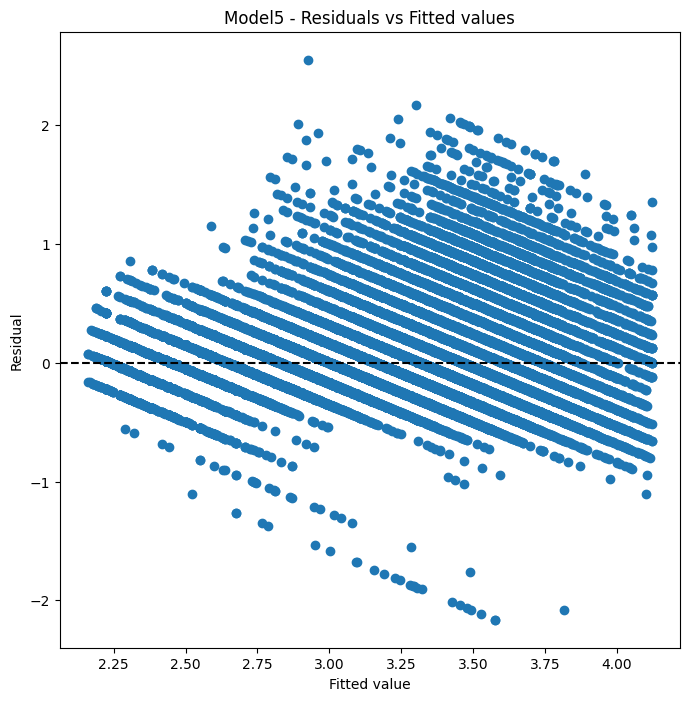

In [36]:
# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(Model5.fittedvalues , Model5.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Model5 - Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

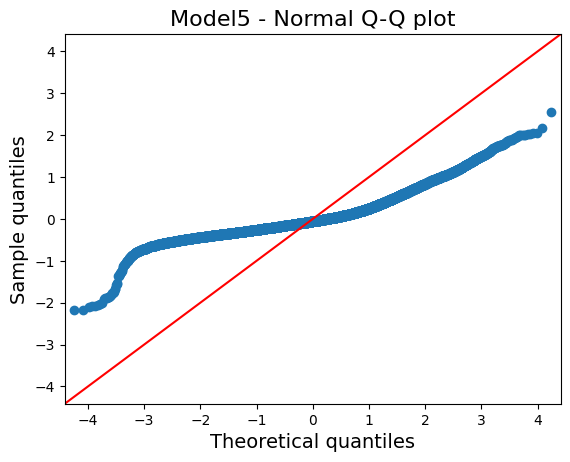

In [37]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(Model5.resid)
p = sm.qqplot(resid, line='45')
plt.title('Model5 - Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

30314

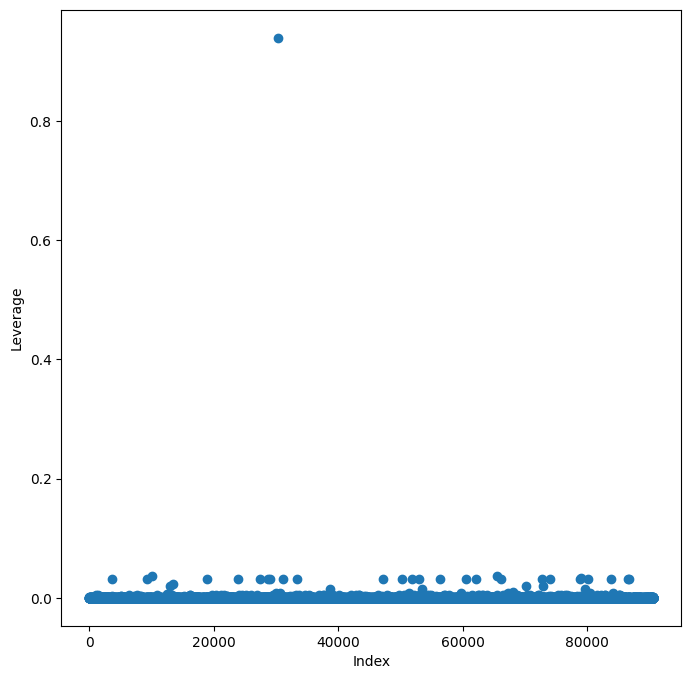

In [38]:
# Calculate Leverage statistics to identify high leverage observations
x = poly_Abalone.transform(AbaloneTrainModelFeatures)
infl = Model5.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(x.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

In [39]:
# calculate VIF to assess multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif)

    VIF Factor                               features
0     4.582148                              intercept
1     1.898978  poly(Shell_weight_Trans, degree=8)[0]
2     1.118706  poly(Shell_weight_Trans, degree=8)[1]
3     1.003362  poly(Shell_weight_Trans, degree=8)[2]
4     1.030144  poly(Shell_weight_Trans, degree=8)[3]
5     1.014419  poly(Shell_weight_Trans, degree=8)[4]
6     1.000118  poly(Shell_weight_Trans, degree=8)[5]
7     1.001859  poly(Shell_weight_Trans, degree=8)[6]
8     1.001903  poly(Shell_weight_Trans, degree=8)[7]
9     2.310960                                  Sex_F
10    2.226465                                  Sex_M


#### __Abalone Regression Model 6 - GAM multivariate regression using smoothing spline functions__

In [40]:
y = AbaloneTrain['Rings_Trans']
AbaloneTrain['Sex_cat'] = AbaloneTrain['Sex'].astype('category',copy=False)

Model6_gam_full = LinearGAM(s_gam(0) + s_gam(1) + s_gam(2) + s_gam(3) + s_gam(4) + s_gam(5) + s_gam(6) + f_gam(7, lam=0))
Xgam = np.column_stack([AbaloneTrain['Length_Trans'] , AbaloneTrain['Diameter_Trans'], AbaloneTrain['Height_Trans'],
                        AbaloneTrain['Whole_weight_Trans'] , AbaloneTrain['Whole_weight1_Trans'], 
                        AbaloneTrain['Whole_weight2_Trans'], AbaloneTrain['Shell_weight_Trans'], AbaloneTrain['Sex_cat'].cat.codes])
Model6_gam_full = Model6_gam_full.fit(Xgam , y)

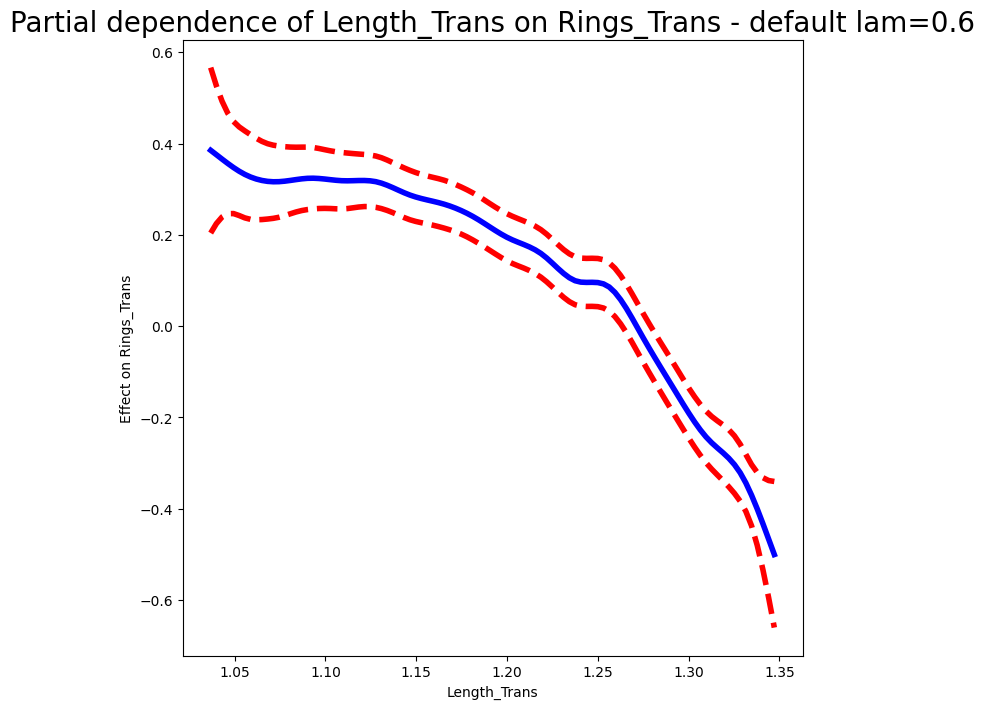

In [41]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 0, ax=ax)
ax.set_xlabel('Length_Trans')
ax.set_ylabel('Effect on Rings_Trans')
ax.set_title('Partial dependence of Length_Trans on Rings_Trans - default lam=0.6',fontsize=20);

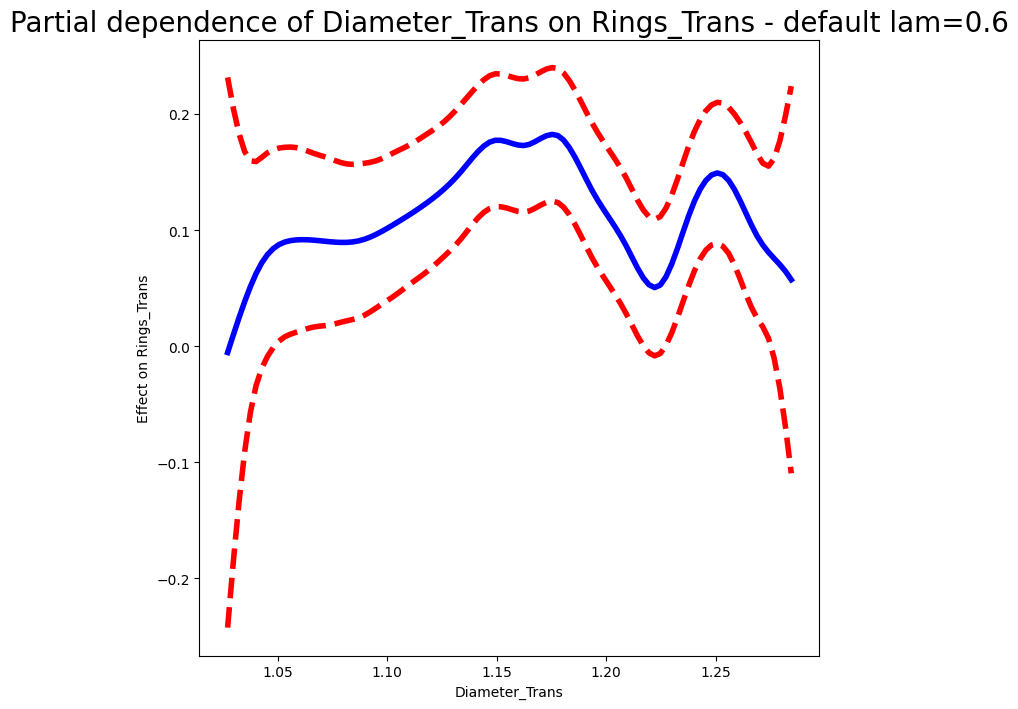

In [42]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 1, ax=ax)
ax.set_xlabel('Diameter_Trans')
ax.set_ylabel('Effect on Rings_Trans')
ax.set_title('Partial dependence of Diameter_Trans on Rings_Trans - default lam=0.6',fontsize=20);

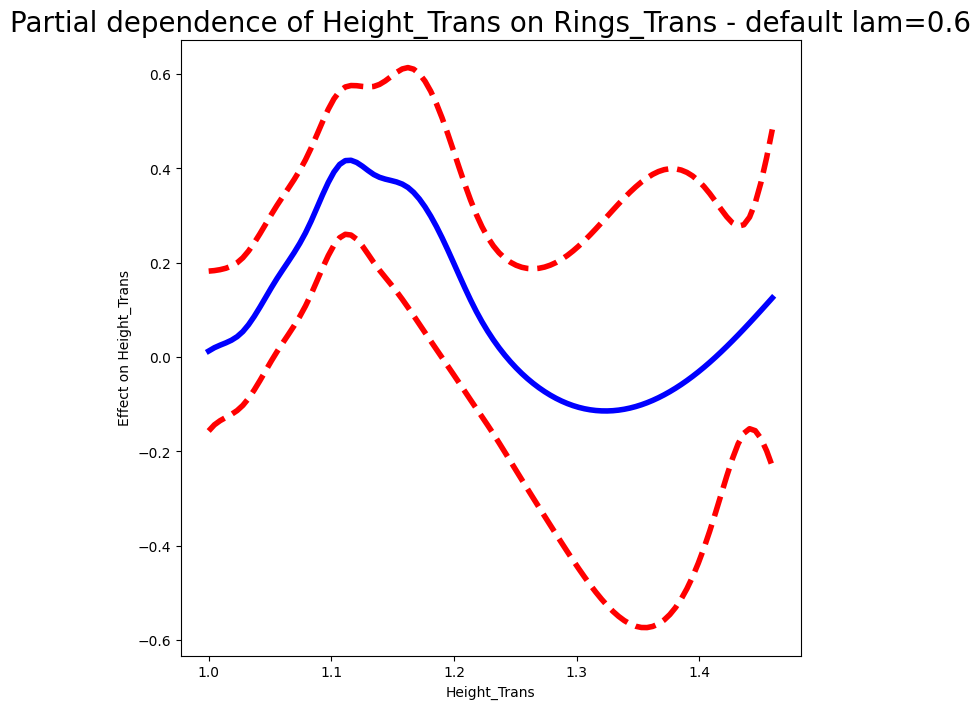

In [43]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 2, ax=ax)
ax.set_xlabel('Height_Trans')
ax.set_ylabel('Effect on Height_Trans')
ax.set_title('Partial dependence of Height_Trans on Rings_Trans - default lam=0.6',fontsize=20);

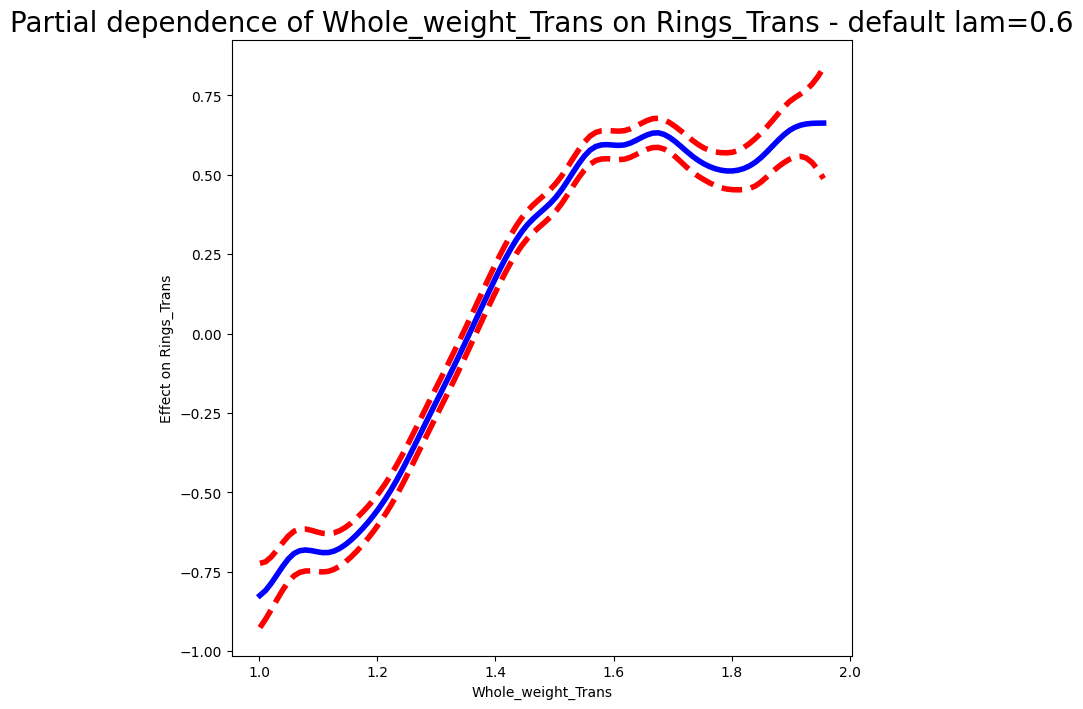

In [44]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 3, ax=ax)
ax.set_xlabel('Whole_weight_Trans')
ax.set_ylabel('Effect on Rings_Trans')
ax.set_title('Partial dependence of Whole_weight_Trans on Rings_Trans - default lam=0.6',fontsize=20);

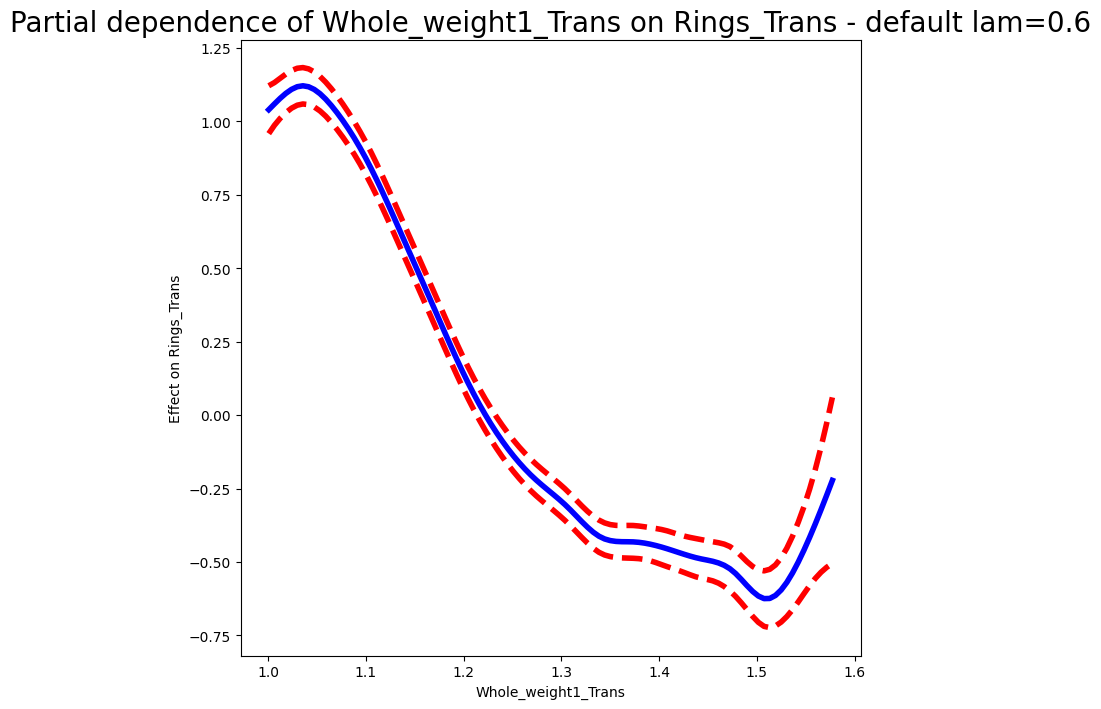

In [45]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 4, ax=ax)
ax.set_xlabel('Whole_weight1_Trans')
ax.set_ylabel('Effect on Rings_Trans')
ax.set_title('Partial dependence of Whole_weight1_Trans on Rings_Trans - default lam=0.6',fontsize=20);

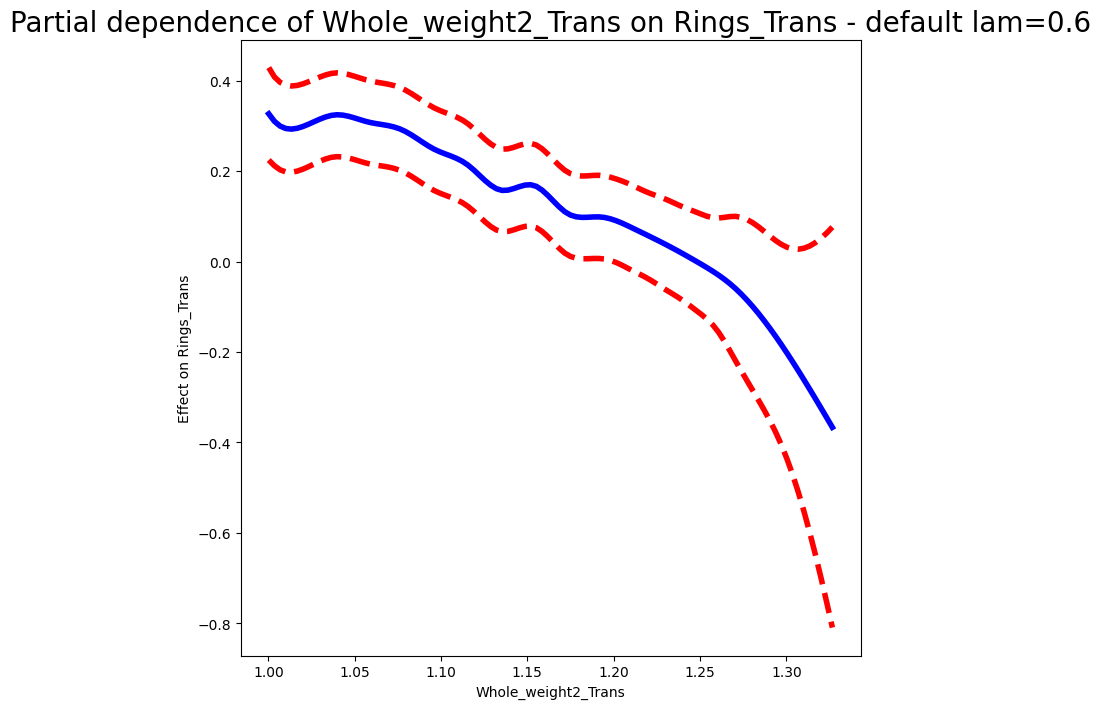

In [46]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 5, ax=ax)
ax.set_xlabel('Whole_weight2_Trans')
ax.set_ylabel('Effect on Rings_Trans')
ax.set_title('Partial dependence of Whole_weight2_Trans on Rings_Trans - default lam=0.6',fontsize=20);

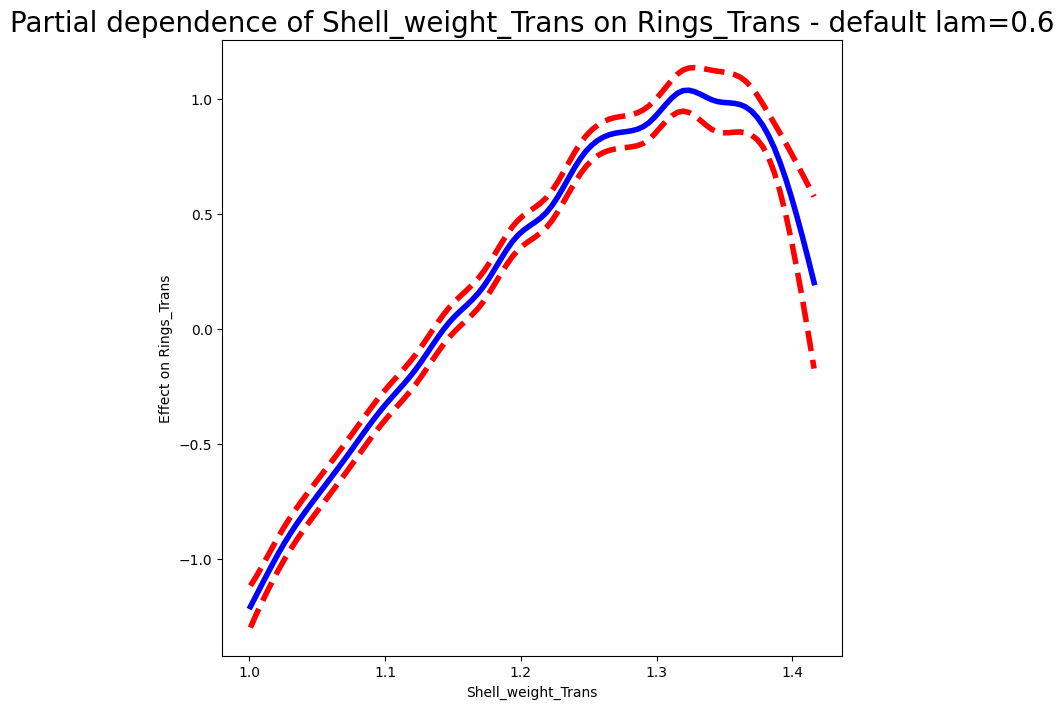

In [47]:
fig , ax = subplots(figsize=(8,8))
plot_gam(Model6_gam_full , 6, ax=ax)
ax.set_xlabel('Shell_weight_Trans')
ax.set_ylabel('Effect on Rings_Trans')
ax.set_title('Partial dependence of Shell_weight_Trans on Rings_Trans - default lam=0.6',fontsize=20);

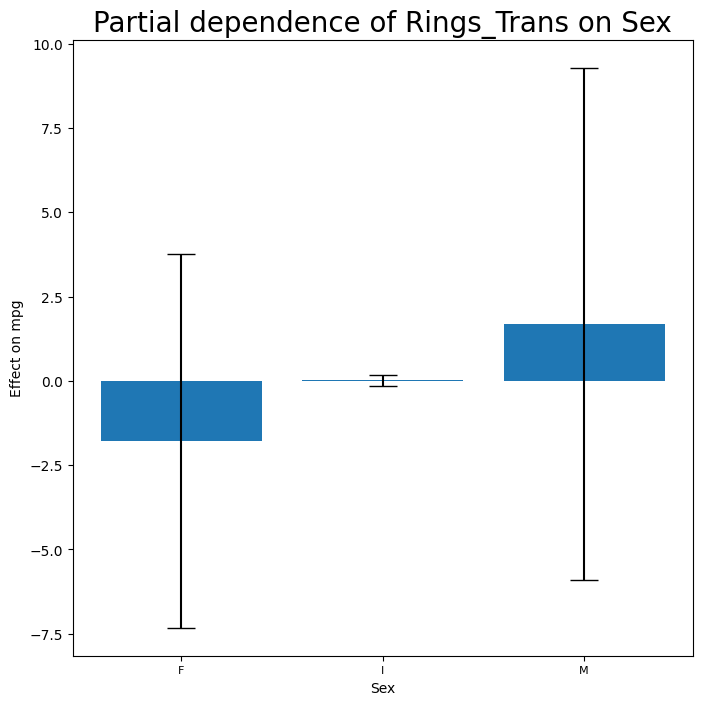

In [48]:
fig , ax = subplots(figsize=(8, 8))
ax = plot_gam(Model6_gam_full , 7)
ax.set_xlabel('Sex')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of Rings_Trans on Sex', fontsize =20);
ax.set_xticklabels(AbaloneTrain['Sex_cat'].cat.categories , fontsize =8);

In [49]:
Model6_gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    105.6731
Link Function:                     IdentityLink Log Likelihood:                               -486278.3828
Number of Samples:                        90615 AIC:                                           972770.1117
                                                AICc:                                          972770.3655
                                                GCV:                                                0.0705
                                                Scale:                                              0.0703
                                                Pseudo R-Squared:                                   0.6776
Feature Function                  Lam

##### __Evaluate Model6__

In [50]:
# evaluate Model6
y_pred = Model6_gam_full.predict(Xgam)
myf(y, y_pred)


 R-squared: 0.678 
 ME: 0.0 
 MPE: -0.006 
 MAE: 0.192 
 MSE: 0.07 
 MAPE: 0.058 
 RMSLE: 0.06


##### __Assess residuals of Model6 to investigate assumptions__

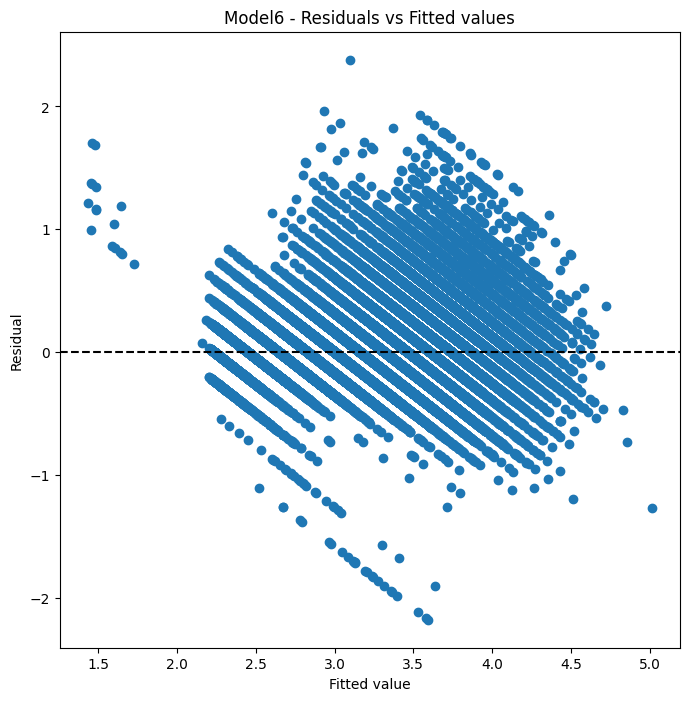

In [51]:
# Get the residuals
residuals = y - y_pred

# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(y_pred , residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Model6 - Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

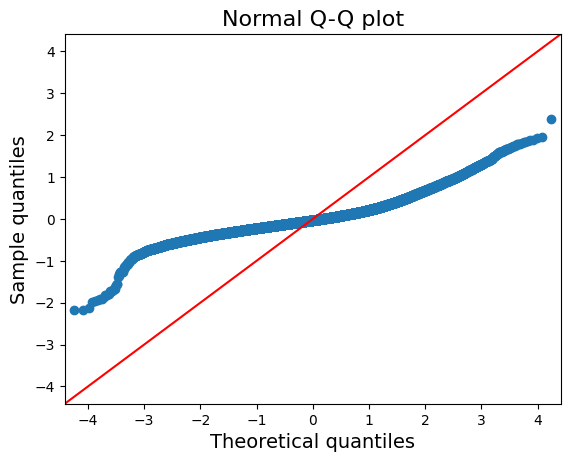

In [52]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(residuals)
p = sm.qqplot(resid, line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

In [53]:
# calculate VIF to assess multicollinearity

# Calculate VIFs for each smooth term
vif = [variance_inflation_factor(Xgam, i) for i in range(Xgam.shape[1])]

# Print VIFs
print(vif)

[33316.47270657369, 44106.48170524651, 16046.432786559139, 2612.9436290020326, 3548.124556408414, 9176.421526272556, 6715.1157512082855, 2.751638530158052]


#### __Generate predictions on the test data__

In [54]:
# import test data
AbaloneTest = pd.read_csv(r'./test.csv')

# rename variables
AbaloneTest.rename(columns={"Whole weight":"Whole_weight","Whole weight.1":"Whole_weight1",
                            "Whole weight.2":"Whole_weight2","Shell weight":"Shell_weight"},inplace=True)

# transform test data and Generate dummy variables for sex
AbaloneTest['Length_Trans'] = np.sqrt(AbaloneTest['Length']+1)
AbaloneTest['Diameter_Trans'] = np.sqrt(AbaloneTest['Diameter']+1)
AbaloneTest['Height_Trans'] = np.sqrt(AbaloneTest['Height']+1)
AbaloneTest['Whole_weight_Trans'] = np.sqrt(AbaloneTest['Whole_weight']+1)
AbaloneTest['Whole_weight1_Trans'] = np.sqrt(AbaloneTest['Whole_weight1']+1)
AbaloneTest['Whole_weight2_Trans'] = np.sqrt(AbaloneTest['Whole_weight2']+1)
AbaloneTest['Shell_weight_Trans'] = np.sqrt(AbaloneTest['Shell_weight']+1)

# Generate dummy variables for sex
Sex = AbaloneTest['Sex']
AbaloneTest = pd.get_dummies(AbaloneTest,columns=['Sex'])
AbaloneTest['Sex'] = Sex
AbaloneTest

,id,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Sex_F,Sex_I,Sex_M,Sex
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1.282576,1.214496,1.074709,1.495995,1.272203,1.145644,1.140395,0,0,1,M
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1.256981,1.208305,1.077033,1.408190,1.215936,1.104310,1.129159,0,0,1,M
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1.249000,1.191638,1.067708,1.356282,1.162970,1.088347,1.113777,0,0,1,M
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1.252996,1.220656,1.070047,1.368941,1.162970,1.089266,1.111306,0,0,1,M
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1.189538,1.151086,1.053565,1.165333,1.075872,1.032957,1.051190,0,1,0,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,1.159741,1.122497,1.041633,1.085127,1.036098,1.013163,1.024695,0,1,0,I
60407,151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.234909,1.187434,1.070047,1.358124,1.178346,1.080278,1.097725,1,0,0,F
60408,151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,1.260952,1.200000,1.074709,1.456709,1.180254,1.095445,1.124722,0,1,0,I
60409,151024,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1.288410,1.234909,1.090871,1.579082,1.260357,1.165118,1.197915,1,0,0,F


In [55]:
# Model5 Predict on the test data
AbaloneTestModelFeatures = AbaloneTest[['Length_Trans','Diameter_Trans','Height_Trans','Whole_weight_Trans','Whole_weight1_Trans',
                                     'Whole_weight2_Trans','Shell_weight_Trans','Sex_F','Sex_M']]

y_pred5 = Model5.predict(poly_Abalone.transform(AbaloneTestModelFeatures))

# use back-transfomration to get predicted rings
Output5 = AbaloneTest
Output5['Rings'] = np.round((np.square(y_pred5) - 1), 0)
Output5

,id,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Sex_F,Sex_I,Sex_M,Sex,Rings
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1.282576,1.214496,1.074709,1.495995,1.272203,1.145644,1.140395,0,0,1,M,11.0
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1.256981,1.208305,1.077033,1.408190,1.215936,1.104310,1.129159,0,0,1,M,11.0
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1.249000,1.191638,1.067708,1.356282,1.162970,1.088347,1.113777,0,0,1,M,10.0
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1.252996,1.220656,1.070047,1.368941,1.162970,1.089266,1.111306,0,0,1,M,10.0
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1.189538,1.151086,1.053565,1.165333,1.075872,1.032957,1.051190,0,1,0,I,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,1.159741,1.122497,1.041633,1.085127,1.036098,1.013163,1.024695,0,1,0,I,6.0
60407,151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.234909,1.187434,1.070047,1.358124,1.178346,1.080278,1.097725,1,0,0,F,10.0
60408,151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,1.260952,1.200000,1.074709,1.456709,1.180254,1.095445,1.124722,0,1,0,I,10.0
60409,151024,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1.288410,1.234909,1.090871,1.579082,1.260357,1.165118,1.197915,1,0,0,F,13.0


In [56]:
# generate output for submission for Model5
Submission5 = Output5[['id','Rings']]
Submission5.to_csv(r'POLYNOM_AbaloneRegressionSubmission5.csv', index = False)
Submission5

,id,Rings
0,90615,11.0
1,90616,11.0
2,90617,10.0
3,90618,10.0
4,90619,8.0
...,...,...
60406,151021,6.0
60407,151022,10.0
60408,151023,10.0
60409,151024,13.0


In [57]:
# Model6 Predict on the test data
AbaloneTest['Sex_cat'] = AbaloneTest['Sex'].astype('category',copy=False)

Xgam = np.column_stack([AbaloneTest['Length_Trans'] , AbaloneTest['Diameter_Trans'], AbaloneTest['Height_Trans'],
                        AbaloneTest['Whole_weight_Trans'] , AbaloneTest['Whole_weight1_Trans'], 
                        AbaloneTest['Whole_weight2_Trans'], AbaloneTest['Shell_weight_Trans'], AbaloneTest['Sex_cat'].cat.codes])


# Get the predicted values
y_pred6 = Model6_gam_full.predict(Xgam)

# use back-transfomration to get predicted rings
Output6 = AbaloneTest
Output6['Rings'] = np.round((np.square(y_pred6) - 1), 0)
Output6

,id,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Length_Trans,Diameter_Trans,...,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Sex_F,Sex_I,Sex_M,Sex,Rings,Sex_cat
0,90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,1.282576,1.214496,...,1.495995,1.272203,1.145644,1.140395,0,0,1,M,9.0,M
1,90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,1.256981,1.208305,...,1.408190,1.215936,1.104310,1.129159,0,0,1,M,10.0,M
2,90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,1.249000,1.191638,...,1.356282,1.162970,1.088347,1.113777,0,0,1,M,11.0,M
3,90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,1.252996,1.220656,...,1.368941,1.162970,1.089266,1.111306,0,0,1,M,10.0,M
4,90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1.189538,1.151086,...,1.165333,1.075872,1.032957,1.051190,0,1,0,I,8.0,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,1.159741,1.122497,...,1.085127,1.036098,1.013163,1.024695,0,1,0,I,6.0,I
60407,151022,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,1.234909,1.187434,...,1.358124,1.178346,1.080278,1.097725,1,0,0,F,9.0,F
60408,151023,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,1.260952,1.200000,...,1.456709,1.180254,1.095445,1.124722,0,1,0,I,12.0,I
60409,151024,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,1.288410,1.234909,...,1.579082,1.260357,1.165118,1.197915,1,0,0,F,13.0,F


In [58]:
# generate output for submission for Model6
Submission6 = Output6[['id','Rings']]
Submission6.to_csv(r'GAM_AbaloneRegressionSubmission6.csv', index = False)
Submission6

,id,Rings
0,90615,9.0
1,90616,10.0
2,90617,11.0
3,90618,10.0
4,90619,8.0
...,...,...
60406,151021,6.0
60407,151022,9.0
60408,151023,12.0
60409,151024,13.0


In [59]:
# Print Python version
import sys
print(sys.version)

# Print Jupyter notebook version
import notebook
notebook.__version__

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


'7.2.2'

In [60]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.29.0
ipykernel        : 6.29.5
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.14.2
jupyterlab       : 4.2.6
nbclient         : 0.10.0
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : 7.2.2
qtconsole        : not installed
traitlets        : 5.14.3
